https://medium.com/swlh/web-scraping-python-requests-and-beautifulsoup-45d5f48f5a1

https://sparkbyexamples.com/spark/spark-read-text-file-rdd-dataframe/

https://medium.com/swlh/text2sql-in-spark-nlp-converting-natural-language-questions-to-sql-queries-on-scale-6ae9a9061d74

https://www.oreilly.com/library/view/learning-spark-2nd/9781492050032/ch04.html

https://www.computerhope.com/issues/ch001721.htm

In [1]:
#!python -m pip install html2text

In [2]:
#!python -m pip install mistletoe

https://github.com/webrecorder/warcio

In [3]:
#!pip install warcio

In [4]:
#!python -m pip install cdx_toolkit

In [5]:
pip install -U gensim

Note: you may need to restart the kernel to use updated packages.


In [6]:
#%load_ext autoreload
#%autoreload 2

Run the cell below to import everything necessary for this analysis.

In [7]:
import json
import sys
import os.path
import re
import logging
import pandas as pd
import requests
import warcio
import mistletoe
import cdx_toolkit
import zlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import string
import warnings
warnings.filterwarnings('ignore')

from warcio import ArchiveIterator
from contextlib import closing
from html2text import HTML2Text
from bs4 import BeautifulSoup
from pathlib import Path
from IPython.display import HTML as HTML_raw, display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from nltk import word_tokenize, FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
np.random.seed(0)

In this analysis, we'll start by creating our own word embeddings by making use of the `Word2Vec` model. Then, we'll move onto building neural networks that make use of Embedding Layers to accomplish the same end-goal, but directly in our model.

* Train a Word2Vec model and transform words into vectors
* Obtain most similar words by using methods associated with word vectors

The easiest way to make use of `Word2Vec` is to import it from the `Gensim` Library. This model contains a full implementation of Word2Vec, which you can use to begin training immediately.

# Our corpus

In this analysis, we'll be working with alomost 100k different documents, each containing one single job AD.

These job AD plain text files are contained within the `\c\Users\renjm\Job-Posting-Big-Data\ana\dat\100k_jobADs` subdirectory, contained within the same folder as this analysis. Each job AD is stored in a single file, with files ranging from `1_2021JAN_jobAD.txt` to `99422_2021JAN_jobAD.txt`.

To make it easy to read in all of the documents, use a list comprehension to create a list containing the name of every single job AD plain text file below.

In [8]:
filesList = []
n_0 = 1
n_1 = 100000
for i in range(n_0, n_1):
    filepath = './dat/100k_jobADs/'+str(i)+'_2021JAN_jobAD.txt'
    if (os.path.exists(filepath)):
        filesList.append(str(i)+'_2021JAN_jobAD.txt')

#print(filesList)

next, let's import one job AD to see what our text looks like so that we can make sure we clean and tokenize it correctly.

read in and print out the `job description` from `59306_2021JAN_jobAD.txt`. Use vanilla Python, no pandas needed.

In [9]:
filepick = './dat/100k_jobADs/59306_2021JAN_jobAD.txt' 
with open(filepick, encoding='utf-8', errors='ignore') as f:
    test_whole_jobad = f.readlines()
    print(test_whole_jobad)

['\n', ' Drivers \n', ' Warehouse \n', ' Hiring Event - Harriman, NY \n', ' Hiring Event - Lexington, SC \n', ' \n', ' LOCAL CDL-A TRUCK DRIVER JOBS WITH DAILY HOME TIME - Enfield, CT \n', ' SEARCH MORE JOBS __ \n', ' Hungry For A Better Truck Driving Career? Join The Martin Brower Private Fleet! \n', ' Martin Brower, a leading supply chain solutions provider for restaurants around the world, is now hiring CDL-A truck drivers for local opportunities. As part of one of the largest privately held companies in the United States, Martin Brower is perfectly equipped to offer CDL professionals incentives that drive their career forward: local routes, daily or nightly home time, 24/7 support and excellent earning potential! \n', " We're a People First company, driven to provide a culture that is focused on safety and committed to the well-being of our world-class team. If you're hungry for better truck driving opportunities, you'll find them here at Martin Brower! \n", ' *** THIS POSITION IS 

## Splitting descriptions associated with qualification/certification from one Job ad text

In [10]:
statesList = ["United States of America","USA","AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS",
              "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA",
              "RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY","DC","GU","MH","MP","PR","VI","Alabama","Alaska",
              "Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho",
              "Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
              "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","Hampshire","Jersey","Mexico","York",
              "Carolina","Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode","Tennessee","Texas","Utah","Vermone",
              "Virginia","Washington","Wisconsin","Wyoming"]
itList = ["Engineer","Scientist","Developer","Analyst","Operator"]
qaList = ["Qualification","Qualifications","Certification","Certifications"]
euList = ["United Kingdom","UK","EU"]

In [11]:
def qa_text(jobad):

    my_jobad = []
    my_qaget = []
    lineCounter = 0
    
    for line in jobad:
        if line != ' \n':
            lineCounter += 1
            my_jobad.append(line)
        else:
            continue
        
        for qa in qaList:
            if qa in line:
                my_qaget.append(lineCounter)
    
    return my_jobad, my_qaget     

In [12]:
my_jobad, my_qaget = qa_text(test_whole_jobad)
print(my_jobad)
print(my_qaget)

['\n', ' Drivers \n', ' Warehouse \n', ' Hiring Event - Harriman, NY \n', ' Hiring Event - Lexington, SC \n', ' LOCAL CDL-A TRUCK DRIVER JOBS WITH DAILY HOME TIME - Enfield, CT \n', ' SEARCH MORE JOBS __ \n', ' Hungry For A Better Truck Driving Career? Join The Martin Brower Private Fleet! \n', ' Martin Brower, a leading supply chain solutions provider for restaurants around the world, is now hiring CDL-A truck drivers for local opportunities. As part of one of the largest privately held companies in the United States, Martin Brower is perfectly equipped to offer CDL professionals incentives that drive their career forward: local routes, daily or nightly home time, 24/7 support and excellent earning potential! \n', " We're a People First company, driven to provide a culture that is focused on safety and committed to the well-being of our world-class team. If you're hungry for better truck driving opportunities, you'll find them here at Martin Brower! \n", ' *** THIS POSITION IS LOCATED

In [13]:
def qa_para(my_jobad, my_qaget, num=5):
    test_jobad = []
    for i in range(0, len(my_jobad)):
        for j in list(set(my_qaget)):
            if i == j:
                #for k in range(len(my_jobad)//2-5, 0, -1):
                for k in range(1, 0, -1):
                    try:
                        test_jobad.append(my_jobad[i-k])
                    except Exception as e:
                        print(e,k)
                #for k in range(0, len(my_jobad)//2-5, 1):
                if len(my_jobad) > (i + num):
                    for k in range(0, num, 1):
                        try:
                            test_jobad.append(my_jobad[i+k])
                        except Exception as e:
                            print(e,k)
                else:
                    for k in range(0, (len(my_jobad) - i), 1):
                        try:
                            test_jobad.append(my_jobad[i+k])
                        except Exception as e:
                            print(e,k)
                
    return test_jobad

In [14]:
test_jobad = qa_para(my_jobad, my_qaget, 5)
print(test_jobad)

[' Local CDL-A Truck Driver Qualifications: \n', ' 21 years of age with Class A CDL \n', ' Must have and maintain acceptable MVR in compliance with DOT \n', ' Minimum 1 year of commercial driving experience or equivalent military experience \n', ' Must pass post-offer background, DOT physical and drug test \n', ' Prior foodservice distribution/delivery experience preferred \n']


## Cleaning and Preprocessing Our Text Data

Now that we have our data, the fun part begins. We'll need to begin by preprocessing and cleaning our text data. As we've seen, preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

These are all questions that we'll need to think about pretty much anytime we begin working with text data.

Let's get right into it. We'll start by getting a list of all of the english stopwords, and concatenating them with a list of all the punctuation.

## Removing Stop Words and Punctuation

`Stop Words` don't contain any interesting information, and essentially just act as the "connective tissue" between the words that really matter in any text. Let's try removing the stopwords and punctuation, and then creating another frequency distribution that contains only the important words.

We've already imported the `stopwords` module. We can access all of the stopwords using the `stopwords.words()` method -- however, we don't want to use the whole thing, as this contains all stopwords in every language supported by NLTK. We don't need to check for and remove any Finnish or Japanese stop words, as this text is in English. To avoid unnecessarily long runtimes, we'll just use the English subset of stopwords by passing in the parameter `"english"` into `stopwords.words()`.

In the cell below:

* Get all the `'english'` stopwords from `stopwords.words()` and store them in the appropriate variable below. They will be stored as a list, by default
* We'll also want to remove all punctuation. Create a list version of `string.punctuation` and add it to our stopwords list
* Finally, we'll also remove numbers. Create a list that contains numbers 0-9 (as strings!), and add this to the stopwords list as well
* Use another list comprehension to get words out of `jobad_tokens` as long as they are not in `stopwords_list`

In [15]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Tokenizing our Data

Before we can create a bag of words or vectorize each document, we need to clean it up and split each job AD into an array of individual words. Computers are very particular about strings. If we tokenized our data in its current state, we would run into the following problems:

* Counting things that aren't actually words. 
* Punctuation and capitalization would mess up our word counts. To the Python interpreter, `love`, `Love`, `Love?`, and `Love\n` are all unique words, and would all be counted separately. We need to remove punctuation and capitalization, so that all words will be counted correctly.

Tokenization is pretty tedious if we handle it manually, and would probably make use of `regular expressions` (**regex**). In order to keep this lab moving, we'll use a library function to clean and tokenize our data so that we can move onto vectorization.

Tokenization is a required task for just about any Natural Language Processing (NLP) task, so great industry-standard tools exist to tokenize things for us, so that we can spend our time on more important tasks without getting bogged down hunting every special symbol or punctuation in a massive dataset. For this analysis, we'll make use of the tokenizer in the amazing `nltk` library, which is short for *Natural Language Tool Kit*.

**NOTE**: `NLTK` requires extra installation methods to be run the first time certain methods are used. If `nltk` throws you an error about needing to install additional packages, follow the instructions in the error message to install the dependencies, and then re-run the cell.

Before we tokenize our job AD plain text files, we'll do only a small manual bit of cleaning. In the cell below, a function that allows us to make every word lowercase, remove newline characters `\n`, and all the following punctuation marks: `",.'?!"` is developed.

Furthermore, this function that not only takes in job AD plain text files having erratic symbols removed but also joins all of the lines into a single string. To sum up, the function, `tokenize_jobAD()`, is utilized to get a fully tokenized version of the job AD. We can test this function on `jobad` to ensure that the function works.

In [16]:
#def process_article(article):
#    tokens = nltk.word_tokenize(article)
#    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
#    return stopwords_removed    

In [17]:
#processed_data = list(map(process_article, data))

In [18]:
def tokenize_jobAD(jobad):
    
    subs = [('.',''),("'",""),('"',''),(',',''),('?',''),('!',''),('\n',''),('\t',''),('\r',''),('|',''),('/',' '),
            ('-',''),('(c)',''),('*',''),('(',''),(')',''),('&',''),(':',''),(';',''),('[',''),(']',''),("\\",""),
            ('â„¢',''),('%',''),('â£',''),('Â£0',''),('Â£',''),('>',''),('<',''),('=',''),('_',''),('__',''),('“',''),
            ('’',''),('–',''),('”',''),('—',''),('+',''),('none',''),('…',''),('•',''),('#',''),('®',''),('â',''),
            ('ufeff',''),("xad",""),("u200e",""),("©",''),("{",''),("}",''),("@",""),("~",""),('$',''),('�',''),('№',''),
            ("ⓒ",""),("●",""),("»",""),("‘",""),("☰",""),("✕",""),("`",""),("´",""),("‐",""),("″",""),("‐",""),
            ("──────────",""),("ue",""),('u200d',''),('u200b',''),("uf09a",""),("u200",""),("u2060",""),("uf0c9",""),
            ("uf400",""),("u200f",""),("uf09a",""),("u200c",""),("uf0a7",""),("uf099",""),("u2066",""),("ue614",""),
            ("uf0fa",""),("uf071",""),("ue61b",""),("uf08c",""),("uf0a8",""),("uf0b7",""),("u202a",""),("ue5d2",""),
            ("ue92b",""),("ue61c",""),("ue613",""),("x86",""),("x96",""),("x92",""),("x7f",""),("x95",""),("x80",""),
            ("x99",""),("x9d",""),("x9c",""),("x97","")]
    pattern = r'[0-9]'
    
    cleaned_jobad = []
    for line in jobad:
        line = re.sub(pattern, '', line)
        for old, new in subs:
            line = line.replace(old, new).lower()
        cleaned_jobad.append(line)

    tokenized_jobad = ' '.join(cleaned_jobad).split()
    tokenized_jobad_no_stopped = [word for word in tokenized_jobad if word not in stopwords_list]
    
    return tokenized_jobad_no_stopped

In [19]:
tokenized_test_jobad_no_stopped = tokenize_jobAD(test_jobad)
print(len(tokenized_test_jobad_no_stopped))
print(tokenized_test_jobad_no_stopped[:100000])

37
['local', 'cdla', 'truck', 'driver', 'qualifications', 'years', 'age', 'class', 'cdl', 'must', 'maintain', 'acceptable', 'mvr', 'compliance', 'dot', 'minimum', 'year', 'commercial', 'driving', 'experience', 'equivalent', 'military', 'experience', 'must', 'pass', 'postoffer', 'background', 'dot', 'physical', 'drug', 'test', 'prior', 'foodservice', 'distribution', 'delivery', 'experience', 'preferred']


Now that we can tokenize our job AD plain text file, we can move onto vectorization.

## Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices. By Vectorizing the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus. Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

`Count Vectorization` allows us to represent a sentence as a vector, with each element in the vector corresponding to how many times that word is used. Notice that when we vectorize a sentence this way, we lose the order that the words were in. This is the `Bag of Words` approach

In the cell below, create a function that takes in a tokenized, cleaned job AD plain text file and returns a count vectorized representation of it as a Python dictionary (aka: *Sparse Representation*). Add in an optional parameter called vocab that defaults to None. This way, if we are using a vocabulary that contains words not seen in the song, we can still use this function by passing it into the vocab parameter.

In [20]:
def count_vectorize(jobad, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(jobad))
    
    jobad_dict = {i:0 for i in unique_words}
    
    for word in jobad:
        jobad_dict[word] += 1
    
    return jobad_dict

In [21]:
test_vectorized_no_stopped = count_vectorize(tokenized_test_jobad_no_stopped)
print(test_vectorized_no_stopped)

{'driver': 1, 'driving': 1, 'distribution': 1, 'preferred': 1, 'postoffer': 1, 'cdla': 1, 'military': 1, 'truck': 1, 'pass': 1, 'minimum': 1, 'maintain': 1, 'compliance': 1, 'qualifications': 1, 'dot': 2, 'must': 2, 'year': 1, 'local': 1, 'equivalent': 1, 'delivery': 1, 'prior': 1, 'acceptable': 1, 'drug': 1, 'physical': 1, 'cdl': 1, 'years': 1, 'age': 1, 'experience': 3, 'mvr': 1, 'commercial': 1, 'test': 1, 'foodservice': 1, 'class': 1, 'background': 1}


We've just successfully vectorized the first job AD plain text document! 

check this text job AD text file to ensure it contains any key word(s) in `qaList`

In [22]:
def qa_usa_Count(filename, tokenized_jobad):
    found_qa = False
    counter_notusa = 0
    counter_qa = 0
    counter_usa = 0
    qaINjobList = []
    qaINusaDict = {}
    
    for eu in euList:
        if eu.lower() in tokenized_jobad.keys():
            counter_notusa += 1
            
    if counter_notusa == 0:
        for qa in qaList:
            if qa.lower() in tokenized_jobad.keys():
                counter_qa += 1
                found_qa = True
                qaINjobList.append(qa)
        if found_qa == True:
            for usa in statesList:
                if usa.lower() in tokenized_jobad.keys():
                    counter_usa += 1
                    qaINusaDict.setdefault(filename, []).append(usa)
            for qa in qaINjobList:
                qaINusaDict.setdefault(filename, []).append(qa)
                
    return counter_qa, counter_usa, qaINusaDict

In [23]:
qaNums_in_test_vectorized, usaNums_in_test_vectorized, qaDict_in_test_vectorized = qa_usa_Count('59306_2021JAN_jobAD', test_vectorized_no_stopped)
print(qaNums_in_test_vectorized)   
print(usaNums_in_test_vectorized)
print(qaDict_in_test_vectorized)

1
0
{'59306_2021JAN_jobAD': ['Qualifications']}


## Getting a list of quality-related job ads

We loop over all job ad plain text files being downloaded from common crawl. require only quality-string-related job AD plain text files be further analyzed. 

* tokenize a corpus of words and identify the different choices to be made while parsing them

* use a count vectorization strategy to create a bag of words

* find quality-related strings from job ads

    - okPass : job AD is likely posted for any jobs avaialble in **North America only** (Canada might be included). in addition, we also require quality-related strings such as `qualification(s)` and `certification(s)`, be found 
    
    - okNotPass : cannot pass rwquirements as conditioned above

* get a word frequency distribution 

In [24]:
def get_list_of_qaJobAds(div=3):
    n_0 = 1
    n_1 = 100000
    qaPassList = []
    okPassList = []
    okNotPassList = []
    for i in range(n_0, n_1):
        qaNums_in_test_vectorized = 0
        usaNums_in_test_vectorized = 0
        filepath = './dat/100k_jobADs/'+str(i)+'_2021JAN_jobAD.txt'
        if (os.path.exists(filepath)):
            filename = filepath.replace('./dat/100k_jobADs/','').replace('.txt','')
            with open(filepath, encoding='utf-8', errors='ignore') as f:
                test_whole_jobad = f.readlines()
            my_jobad, my_qaget = qa_text(test_whole_jobad) 
            test_jobad = qa_para(my_jobad, my_qaget)
            tokenized_test_jobad_no_stopped = tokenize_jobAD(test_jobad)
            test_vectorized_no_stopped = count_vectorize(tokenized_test_jobad_no_stopped)
            qaNums_in_test_vectorized, usaNums_in_test_vectorized, qaDict_in_test_vectorized_no_stopped = qa_usa_Count(filename, test_vectorized_no_stopped)
            if (qaNums_in_test_vectorized > 0):
                if (i%div == 0):
                    qaPassList.append(qaDict_in_test_vectorized_no_stopped) 
                    okPassList.append(i)
            else:
                if (i%(div*6) == 0): 
                    okNotPassList.append(i)
        else:
            continue
                
    return qaPassList, list(set(okPassList)), list(set(okNotPassList))

* okPass : found **at least one word string** from every single job AD plain text file in **both** `statesList` and `qaList` string lists, respectively

* okNotPass: doesn't satisfy the requirement above 

In [25]:
qaPassList, okPassList, okNotPassList = get_list_of_qaJobAds(1) # div=1 means ALL

In [26]:
#print(okPassList)

In [27]:
print(len(okPassList))
print(len(okNotPassList))

3230
6000


In [28]:
#print(okNotPassList)

In [29]:
myList = []
okNotPassFile = './okNotPass.txt' 
with open(okNotPassFile, encoding='utf-8', errors='ignore') as f:
    myList = list(map(int, f.readlines()))
    
#print(myList)

In [30]:
okNewPassList = okPassList.copy()
for i in myList:
    if i in okNewPassList:
        okNewPassList.remove(i)
        
print(len(okNewPassList))

3224


## Processing All Quality-Related Job Ad Documents

* Let's create another frequency distribution using `tokenized`, and then inspect the top 50 most common words, to see if removing stopwords and punctuation has helped.

* Now that we have a frequency distribution, we can easily answer Q7 about a list of selected job ad plain text files. Let's answer some basic questions about `QAjobad` below, before we move onto creating bigrams.

next, create an empty DataFrame called `QAjobads_df`. As we read in job ads and store and clean them, we'll store them in this DataFrame.

In [31]:
def get_data(okList, docs=10):
    
    doc_counter = 0
    # Iterate through list of filenames and read each in
    tokenized_all_documents = {}
    for fileNo in okList:
        filepath = './dat/100k_jobADs/'+str(fileNo)+'_2021JAN_jobAD.txt'
        if (os.path.exists(filepath)):
            if (docs > 0):
                doc_counter += 1
            with open(filepath, encoding='utf-8', errors='ignore') as f:
                raw_data = f.readlines()
        
        # split qualify-associated descriptions from raw text
        my_jobad, my_qaget = qa_text(raw_data) 
        my_qa_jobad = qa_para(my_jobad, my_qaget)
        
        # Clean and tokenize raw text
        tokenized = tokenize_jobAD(my_qa_jobad)
        tokenized_all_documents[doc_counter-1] = tokenized
        
        if (doc_counter > 0) & (doc_counter >= docs):
            break 
    
    return tokenized_all_documents

In [32]:
tokenized_data = get_data(okNewPassList, 5000)
print(len(tokenized_data))

3224


In [33]:
print(tokenized_data[0])

['filed', 'audit', 'certification', 'employment', 'technology', 'tagged', 'big', 'cisa', 'experience', 'inexperienced', 'auditor', 'project', 'volunteer', 'top', 'reasons', 'auditor', 'hard', 'audit', 'management', 'sometimes', 'sucks', 'responses', 'get', 'audit', 'job', 'little', 'experience', 'pingback', 'get', 'audit', 'job', 'little', 'experience', 'cyber', 'security', 'cisa', 'vs', 'cia', 'certification', 'acl', 'add', 'conditional', 'computed', 'field', 'free', 'cisa', 'study', 'guide', 'acl', 'analytics', 'dying', 'excel', 'identify', 'duplicates', 'categories', 'categories', 'select', 'category', 'acl', 'audit', 'blogging', 'case', 'files', 'certification', 'data', 'analytics', 'employment', 'excel', 'fraud', 'free', 'free', 'download', 'humor', 'irony', 'poll', 'quote', 'weak', 'scripting', 'acl', 'security', 'security', 'scope', 'security', 'scout', 'technology', 'top', 'uncategorized', 'written', 'skyyler', 'links', 'follow', 'twitter', 'hidden', 'audit', 'security', 'resou

In [34]:
print(tokenized_data[1])

['qualifications', 'ideal', 'candidate', 'minimum', 'years', 'commercial', 'collections', 'experienc', 'excellent', 'communication', 'skills', 'oral', 'written', 'english', 'french', 'asset', 'strong', 'microsoft', 'office', 'applications', 'proficient', 'excel']


In [35]:
print(tokenized_data[2])

['qualifications', 'great', 'attitude', 'willingness', 'lead', 'attention', 'detail', 'store', 'always', 'looks', 'great', 'confidence', 'handling', 'real', 'responsibility', 'willingness', 'help', 'solve', 'problems', 'minimum', 'qualificationsoutlined', 'required', 'minimum', 'qualifications', 'position', 'listed', 'minimum', 'qualifications', 'age', 'older', 'preferred', 'qualificationsoutlined', 'optional', 'preferred', 'qualifications', 'position', 'listed', 'preferred', 'qualifications', 'walmart', 'accommodate', 'disabilityrelated', 'needs', 'applicants', 'associates', 'required', 'law', 'youll', 'leader', 'coach', 'team', 'playerall', 'rolled', 'one', 'takes', 'special', 'kind', 'person', 'department', 'manager', 'walmartbecause', 'every', 'bit', 'committed', 'team', 'culture', 'customers', 'matter', 'department', 'managers', 'friendly', 'confident', 'communicators', 'know', 'get', 'best', 'teamand', 'theyve', 'got', 'leadership', 'skills', 'make', 'people', 'want', 'perform', 

In [36]:
QAjobads_df = pd.Series(tokenized_data) 

In [37]:
QAjobads_df[:5]

0    [filed, audit, certification, employment, tech...
1    [qualifications, ideal, candidate, minimum, ye...
2    [qualifications, great, attitude, willingness,...
3    [qualifications, male, female, must, years, ag...
4    [aca, acca, qualification, essential, role, co...
dtype: object

Notice that although the words are tokenized, they are still in the same order they were in as headlines. This is important, because the words need to be in their original order for Word2Vec to establish the meaning of them. Remember that for a `Word2Vec` model I can specify a Window Size that tells the model how many words to take into consideration at one time.

If my window size was 5, then the model would start by looking at the words "Will Smith joins Diplo and", and then slide the window by one, so that it's looking at "Smith joins Diplo and Nicky", and so on, until it had completely processed the text example at index 1 above. By doing this for every piece of text in the entire dataset, the `Word2Vec` model learns excellent vector representations for each word in an Embedding Space, where the relationships between vectors capture semantic meaning (recall the vector that captures gender in the previous "`king - man + woman = queen`" example I saw).

Now that I've prepared the data, train my model and explore a bit!

## Training the Model

Start by instantiating a `Word2Vec` Model from `gensim`.

In the cell below:

* Create a `Word2Vec` model and pass in the following arguments:
    - The dataset we'll be training on, `QAjobads_df`
    - The size of the word vectors to create, `size=100`
    - The window size, `window=5`
    - The minimum number of times a word needs to appear in order to be counted in the model, `min_count=1`
    - The number of threads to use during training, `workers=4`

In [38]:
model = Word2Vec(QAjobads_df, size=100, window=5, min_count=1, workers=4)

Now, that I've instantiated Word2Vec model, train it on my text data.

In the cell below:

* Call the `.train()` method on my model and pass in the following parameters:

    - The dataset we'll be training on, `QAjobads_df`
    - The `total_examples` of sentences in the dataset, which I can find in `model.corpus_count`
    - The number of `epochs` I want to train for, which we'll set to `10`

In [39]:
model.train(QAjobads_df, total_examples=model.corpus_count, epochs=10)

(2897427, 3168970)

Ok. We now have a fully trained model! The word vectors themselves are stored in the `Word2VecKeyedVectors` instance, which is stored in the `.wv` attribute. To simplify this, restore this object inside of the variable `wv` to save myself some keystrokes down the line.

In [40]:
wv = model.wv

## Examining Your Word Vectors

Now that I have a trained `Word2Vec` model, go ahead and explore the relationships between some of the words in the corpus!

One cool thing I can use `Word2Vec` for is to get the most similar words to a given word. I can do this by passing in the word to `wv.most_similar()`.

In the cell below, try getting the most similar word to `'qualification'`.

In [41]:
wv.most_similar('qualification')

[('btech', 0.7779676914215088),
 ('mca', 0.7596356272697449),
 ('bca', 0.7205610871315002),
 ('stream', 0.7089898586273193),
 ('gnm', 0.7015988826751709),
 ('mcom', 0.6835454702377319),
 ('tradespeople', 0.6825571060180664),
 ('electrician', 0.6811347007751465),
 ('mba', 0.6808139085769653),
 ('iti', 0.6792859435081482)]

In [42]:
print(wv.most_similar('qualification')[0])
print(wv.most_similar('qualification')[0][0])
print(wv.most_similar('qualification')[0][1])

('btech', 0.7779676914215088)
btech
0.7779676914215088


In [43]:
wv.most_similar('experience')

[('preferably', 0.6606717109680176),
 ('setting', 0.6533883810043335),
 ('jms', 0.5967622995376587),
 ('five', 0.5701263546943665),
 ('prior', 0.5699166655540466),
 ('supervisory', 0.563443660736084),
 ('years', 0.5385386943817139),
 ('acute', 0.5352734327316284),
 ('least', 0.5316807627677917),
 ('ideally', 0.5210566520690918)]

In [44]:
wv.most_similar('skill')

[('worth', 0.711178719997406),
 ('itpilipinascom', 0.6467073559761047),
 ('celebrating', 0.6370295882225037),
 ('enthusiasmyou', 0.5919318795204163),
 ('effects', 0.5675952434539795),
 ('induction', 0.5672016739845276),
 ('animations', 0.5559437274932861),
 ('proofread', 0.5524944067001343),
 ('set', 0.5394076108932495),
 ('representative', 0.5166015028953552)]

In [45]:
wv.most_similar('ability')

[('able', 0.7044336795806885),
 ('effectively', 0.6483671069145203),
 ('priorities', 0.645809531211853),
 ('multiple', 0.6457312703132629),
 ('prioritize', 0.6390169858932495),
 ('dispute', 0.6141330003738403),
 ('initiative', 0.612598180770874),
 ('effective', 0.6111854314804077),
 ('changing', 0.591248095035553),
 ('deadlines', 0.5876355171203613)]

Interesting! All of the most similar words are also states.

I can also get the least similar vectors to a given word by passing in the word to the `.most_similar()` method's `negative` parameter.

In the cell below, get the least similar words to `'qualifications'`.

In [46]:
#wv.most_similar(negative='qualification')

In [47]:
#wv.most_similar(negative='experience')

This seems like random noise. It is a result of the way Word2Vec is computing the similarity between word vectors in the embedding space. Although the word vectors closest to a given word vector are almost certainly going to have similar meaning or connotation with my given word, the word vectors that the model considers 'least similar' are just the word vectors that are farthest away, or have the lowest cosine similarity. It's important to understand that while the closest vectors in the embedding space will almost certainly share some level of semantic meaning with a given word, there is no guarantee that this relationship will hold at large distances.

I can also get the vector for a given word by passing in the word as if I was passing in a key to a dictionary.

In the cell below, get the word vector for `'qualifications'`.

In [48]:
wv['qualifications']

array([ 5.02492666e-01, -3.52354503e+00, -4.38093871e-01,  1.24926731e-01,
       -1.57396877e+00, -6.03500545e-01, -1.73832107e+00,  1.45441973e+00,
       -3.60719055e-01, -5.84143758e-01,  4.79222417e-01, -6.89827561e-01,
        4.92852867e-01, -1.22315526e+00, -5.62417567e-01,  3.23583460e+00,
        6.39881372e-01,  7.43721306e-01,  1.04208446e+00,  4.09149602e-02,
       -1.45414472e+00,  3.22265655e-01,  5.70234954e-01,  3.43295544e-01,
        1.31793666e+00,  1.52214438e-01,  3.60209167e-01,  3.50681394e-02,
        2.99490076e-02,  6.11646950e-01, -1.70250431e-01,  8.54997575e-01,
        3.68684530e-02,  1.32731363e-01,  9.41225708e-01,  9.87337887e-01,
       -4.58075218e-02, -1.74158916e-01, -8.26987147e-01,  2.09983349e+00,
       -3.97752136e-01,  3.75093400e-01, -1.56911719e+00,  1.02093303e+00,
        6.13996685e-01, -1.76633954e-01, -2.95676529e-01,  6.67758167e-01,
       -5.04253507e-01,  2.04843521e+00,  1.26148565e-02, -3.50349396e-01,
       -1.71674716e+00, -

Now get all of the word vectors from the object at once. I can find these inside of `wv.vectors`. Try it out in the cell below.

In [49]:
wv.vectors

array([[ 0.50249267, -3.523545  , -0.43809387, ...,  0.04045786,
         1.2719796 , -0.3810344 ],
       [-0.15500763, -1.5389404 ,  1.5816706 , ...,  1.6665643 ,
         1.9992096 , -2.539942  ],
       [ 1.0333763 , -1.2808625 ,  0.9082382 , ...,  3.6170566 ,
         0.09788132,  0.5686611 ],
       ...,
       [ 0.02781985,  0.00926474,  0.01874588, ..., -0.04967662,
         0.01899238, -0.01798851],
       [ 0.04974647, -0.02714864,  0.0118499 , ...,  0.01378644,
        -0.02013495,  0.01655838],
       [ 0.03899157, -0.02170335,  0.00560585, ..., -0.02478539,
         0.06675352, -0.03945508]], dtype=float32)

As a final experiment, try to recreate the `'king' - 'man' + 'woman' = 'queen'` example previously mentioned. I can do this by using the `.most_similar()` method and translating the word analogies into an addition/subtraction formulation (as shown above). Pass the original comparison, which you are calculating a difference between, to the negative parameter, and the analogous starter you want to apply the same transformation to, to the positive parameter.

Do this now in the cell below.

In [50]:
wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('apartments', 0.7927402853965759),
 ('walkup', 0.7795013189315796),
 ('alter', 0.7669872045516968),
 ('suited', 0.7595961689949036),
 ('learningcentred', 0.7580158710479736),
 ('devise', 0.7579994201660156),
 ('condominiums', 0.7484898567199707),
 ('moshi', 0.7444189786911011),
 ('enjoyment', 0.7433988451957703),
 ('inefficiency', 0.7414690256118774)]

As you can see from the output above, your model isn't perfect, but 'Queen' and 'Princess' are still in the top 5. As you can see from the other word in top 5, 'reminiscent' -- your model is far from perfect. This is likely because you didn't have enough training data. That said, given the small amount of training data provided, the model still performs remarkably well!

In the following, I'll utilize transfer learning, loading in the weights from an open-sourced model that has already been trained for a very long time on a massive amount of data. Specifically, I'll work with the GloVe model from the Stanford NLP Group. There's not really any benefit from training the model ourselves, unless my text uses different, specialized vocabulary that isn't likely to be well represented inside an open-source model.

# Visualization

In [51]:
def top_count_bar_chart(keyword):
    
    sns.set_context('notebook')
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
    colors = ["b", "g", "r", "c", "m", "y", "k", "purple"] # colors for every line of y
    
    kList = wv.most_similar(keyword)
    xList = []
    yList = []
    
    for i in range(0, 10):
        xList.append(kList[i][0])
        yList.append(kList[i][1])
        ax.bar(xList[i], yList[i], color=colors[i%8], alpha=0.5)
        
    ax.set_title('Trained Word2Vec4`{}`'.format(keyword), size=50)
    ax.set_xlabel('Top 10 Most Similar Words', size=30)
    ax.set_ylabel("Similarity", size=30)
    ax.set_yticklabels(yList, fontsize=30)
    ax.set_xticklabels(xList, fontsize=30, rotation=60, ha='right')
    ax.set(yscale='linear')

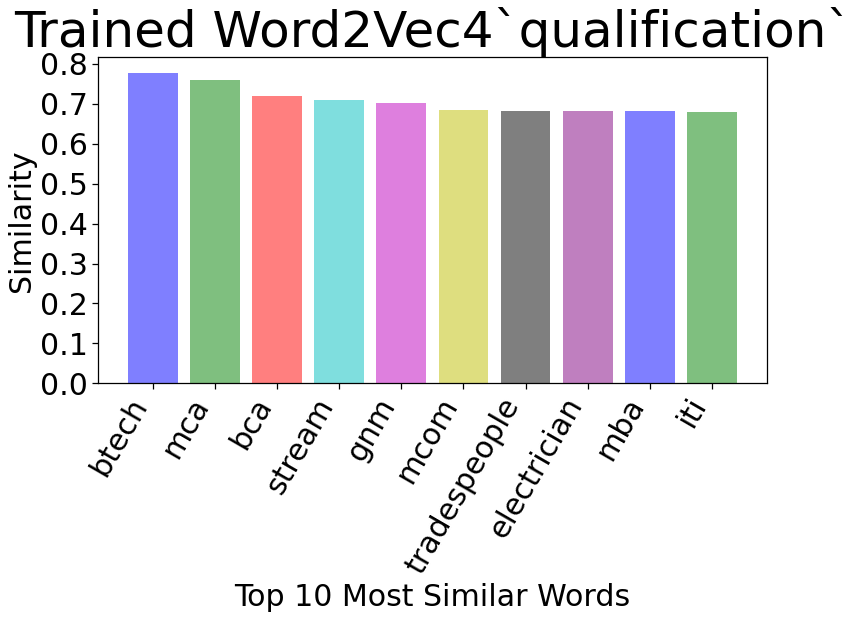

In [52]:
top_count_bar_chart('qualification')

In this analysis, we trained and used a Word2Vec model to create vectorized word embeddings!